In [1]:
import feedparser
import bs4
import requests
import pandas as pd
import re
import os.path
import numpy as np
from collections import OrderedDict
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth', 100)

In [2]:
# make a list of search page urls
unsearched_urls = []
unsearched_urls.append('http://sfbay.craigslist.org/search/sfc/apa?')
for i in range(1,25):    
    unsearched_urls.append('http://sfbay.craigslist.org/search/sfc/apa?s=%d00' % i)

In [3]:
def get_html(url, html_list):
    try:
        r = requests.get(url, timeout=1)
        r.raise_for_status()
    except Exception:
        return
    html = bs4.BeautifulSoup(r.text)
    html_list.append(html)

In [4]:
def find_unsearched(search_html, search_urls, re_term):
    searched_urls = re.findall(re_term, str(search_html))
    searched_urls = list(OrderedDict.fromkeys(searched_urls))
    unsearched_urls = list(set(search_urls) - set(searched_urls))
    return unsearched_urls

## search

In [5]:
%%time
# use urls to get all html from pages
search_page_html = []
re_search = 'http\:\/\/sfbay\.craigslist\.org\/search\/sfc\/apa\?(?:s\=\d+)?'

def get_search_html(url, html_list):

    try:
        r = requests.get(url, timeout=1)
        r.raise_for_status()

    except Exception:
        return

    html_list.append(r.text)
    

for i in range(3):    
    for url in unsearched_urls:
        get_search_html(url, search_page_html)
    searched_urls = re.findall(re_search, str(search_page_html))
    searched_urls = list(OrderedDict.fromkeys(searched_urls))
    unsearched_urls = list(set(unsearched_urls) - set(searched_urls))
    print 'pages scraped: ', len(searched_urls)
    print 'number of unsearched urls: ', len(unsearched_urls)

pages scraped:  25
number of unsearched urls:  0
pages scraped:  25
number of unsearched urls:  0
pages scraped:  25
number of unsearched urls:  0
CPU times: user 235 ms, sys: 58.8 ms, total: 294 ms
Wall time: 11.3 s


In [6]:
url_links_end_half = []

url_links_end_half = re.findall('\/sfc\/apa\/\d+\.html', str(search_page_html))
len(url_links_end_half)

5000

In [7]:
# there are duplicates
print 'number of duplicates: ', len(url_links_end_half)

# check and see all urls are unique
links_list = list(OrderedDict.fromkeys(url_links_end_half))
print 'number of unique links kept: ', len(links_list)

number of duplicates:  5000
number of unique links kept:  2491


In [8]:
# append the pieces of the urls to the beginning part
url_links = []
for i in links_list:
    url_links.append('http://sfbay.craigslist.org%s' % i)
print 'did it come out right? ', url_links[0]

did it come out right?  http://sfbay.craigslist.org/sfc/apa/4985368983.html


In [9]:
df_final = pd.read_csv('../craigslist_data/df_final.csv')

In [10]:
master_list = df_final.url.tolist()

In [11]:
unscraped_links = set(url_links) - set(master_list)
print 'how many is not already in the data set: ', len(unscraped_links)

how many is not already in the data set:  1883


In [12]:
%%time
links_html = []
re_link = 'http\:\/\/sfbay\.craigslist\.org\/sfc\/apa\/\d+\.html'


for i in range(3):
    for url in unscraped_links:
        get_html(url, links_html)
    unscraped_links = find_unsearched(links_html, unscraped_links, re_link)
    print 'length of unsearched: ', len(unscraped_links)


length of unsearched:  2
length of unsearched:  0
length of unsearched:  0
CPU times: user 1min 10s, sys: 3.68 s, total: 1min 14s
Wall time: 4min 55s


len(links_html)
html_master_pre_df = pd.read_csv('../craigslist_data/html_master_df.csv')
html_master_pre_df.info()

html_master_pre_list = html_master_pre_df.values.tolist()
html_master_list = html_master_pre_list + links_html

html_no_dup = list(html_master_list for html_master_list,_ in itertools.groupby(html_master_list))
print 'number of html listings: ', len(html_master_list)
print 'number of unique html listings: ', len(html_no_dup)

In [13]:
# all regex expressions in an ordered dictionary

# OrderedDict() keeps the columns ordered in a data frame

import collections

flt_columns = collections.OrderedDict()
flt_columns['rent'] = 'price\"\>\$\d+(?:\,\d+)?'
flt_columns['sq_ft'] = '(\d+)</b>[ft]'
flt_columns['bedrooms'] = '<span><b>([0-9])<\/b>BR'
flt_columns['bathrooms'] = '<b>([0-9]*\.?[0-9]+)</b>Ba'
flt_columns['neighborhood'] = "small\>\s+\(([^\(\)]+)\)\<\/small"
flt_columns['latitude'] = '="\d+\.\d+"'
flt_columns['longitude'] = '="-\d+\.\d+"'

apa_columns = collections.OrderedDict()
apa_columns['type_apartment'] = '<span>apartment'
apa_columns['type_condo'] = '<span>condo'
apa_columns['type_cottage/cabin'] = '<span>cottage\/cabin'
apa_columns['type_duplex'] = '<span>duplex'
apa_columns['type_flat'] = '<span>flat'
apa_columns['type_house'] = '<span>house'
apa_columns['type_in-law'] = '<span>in-law'
apa_columns['type_loft'] = '<span>loft'
apa_columns['type_townhouse'] = '<span>townhouse'
apa_columns['type_manufactured'] = '<span>manufactured'
apa_columns['type_assisted_living'] = '<span>assisted living'
apa_columns['type_land'] = '<span>land'

rd_columns = collections.OrderedDict()
rd_columns['carport'] = '<span>carport'
rd_columns['attached_garage'] = '<span>attached garage'
rd_columns['detached_garage'] = '<span>detached garage'
rd_columns['off_street_parking'] = '<span>off-street parking'
rd_columns['street_parking'] = '<span>street parking'
rd_columns['valet_parking'] = '<span>valet parking'

ld_columns = collections.OrderedDict()
ld_columns['laundry_in_bldg'] = '<span>laundry in bldg'
ld_columns['w/d_in_unit'] = '<span>w\/d in unit'
ld_columns['laundry_on_site'] = '<span>laundry on site'
ld_columns['w/d_hookups'] = '<span>w\/d hookups'

cd_columns = collections.OrderedDict()
cd_columns['cats_OK'] = '(cats are OK)'
cd_columns['dogs_OK'] = '(dogs are OK)'

ran_columns = collections.OrderedDict()
ran_columns['wheelchair accessible'] = '<span>wheelchair accessible'
ran_columns['no smoking'] = '<span>no smoking'
ran_columns['furnished'] = '<span>furnished'

url_columns = collections.OrderedDict()
url_columns['url'] = 'http:\/\/sfbay.craigslist.org\/sfc\/apa\/\d+\.html'
url_columns['post_id'] = 'post id: \d+'
url_columns['date_time'] = 'datetime\=\"\d+\-\d+\-\d+'

In [14]:
columns_not_url = collections.OrderedDict(flt_columns.items() +
                                  apa_columns.items() +
                                  rd_columns.items() +
                                  ld_columns.items() +
                                  ran_columns.items()+
                                  cd_columns.items())

In [15]:
columns = collections.OrderedDict(columns_not_url.items() + url_columns.items())


In [16]:
feature = re.findall(flt_columns['neighborhood'], str(links_html))

In [17]:
len(feature)

1868

In [18]:
len(links_html)

1883

In [19]:
%%time
features_list = []
def get_features(html_list):
    for html in html_list:
        # new list for a listings features
        features = []
        for key in columns:
            # extract individual feature
            feature = re.findall(columns[key], str(html))
            # make a list of features for the listing's html
            features.append(feature)
        # make a list of listings' features
        features_list.append(features)
get_features(links_html)

CPU times: user 7min 6s, sys: 5.88 s, total: 7min 12s
Wall time: 7min 14s


In [20]:
%%time
def list_to_df(lst):
    return pd.DataFrame(lst, columns = columns)
    
features_df = list_to_df(features_list)

CPU times: user 11.9 ms, sys: 3.13 ms, total: 15 ms
Wall time: 41 ms


In [21]:
features_df.head(2)

,rent,sq_ft,bedrooms,bathrooms,neighborhood,latitude,longitude,type_apartment,type_condo,type_cottage/cabin,...,laundry_on_site,w/d_hookups,wheelchair accessible,no smoking,furnished,cats_OK,dogs_OK,url,post_id,date_time
0,"[price"">$2915]",[332],[0],[1],[inner sunset / UCSF],"[=""37.759540""]","[=""-122.462864""]",[<span>apartment],[],[],...,[],[],[<span>wheelchair accessible],[],[],[cats are OK],[dogs are OK],[http://sfbay.craigslist.org/sfc/apa/4984983237.html],[post id: 4984983237],"[datetime=""2015-04-18, datetime=""2015-04-18]"
1,"[price"">$5595]",[],[3],[2],[potrero hill],"[=""37.762246""]","[=""-122.395523""]",[],[],[],...,[<span>laundry on site],[],[],[],[],[],[],[http://sfbay.craigslist.org/sfc/apa/4979470575.html],[post id: 4979470575],"[datetime=""2015-04-14, datetime=""2015-04-14, datetime=""2015-04-17]"


## clean re

In [22]:
def cleandata(string):
    string = string.replace('[', '')
    string = string.replace(']', '')
    string = string.replace("'", '')

    return string

for col in columns:
    features_df[col] = features_df[col].astype(str).map(lambda x: cleandata(x))

In [23]:
def cleandata(string):
    string = string.replace('span', '')
    string = string.replace('price', '')
    string = string.replace('<', '')
    string = string.replace('>', '')
    string = string.replace('\\n', '')
    string = string.replace('/', '')
    string = string.replace('\\', '')
    string = string.replace('$', '')
    string = string.replace('"', '')
    string = string.replace('=', '')


    return string

for col in columns_not_url:
    features_df[col] = features_df[col].astype(str).map(lambda x: cleandata(x))

In [24]:
features_df.post_id = features_df.post_id.str.replace(r'[^\d]+', '')

In [25]:
for col in features_df:
    if features_df[col].dtype == object:
        features_df[col] = features_df[col].str.lower()

## apartments

In [26]:
features_df['apa'] = ''

In [27]:
# get all housing type names
apa_names = apa_columns.keys()

In [28]:
# add each column to the blank space
for col in apa_names:
    features_df['apa'] = features_df['apa'].map(str) + features_df[col].map(str)

In [29]:
features_df = features_df.drop(apa_columns.keys(), axis = 1)

## laundry

In [30]:
features_df['laundry'] = ''
for col in ld_columns.keys():
    features_df['laundry'] += features_df[col].map(str)

In [31]:
features_df['laundry'].value_counts()

wd in unit         705
laundry in bldg    586
                   431
laundry on site    132
wd hookups          29
dtype: int64

In [32]:
features_df = features_df.drop(ld_columns.keys(), axis = 1)

## parking

In [33]:
features_df['parking'] = ''
for col in rd_columns.keys():
    features_df['parking'] += features_df[col].map(str)

In [34]:
features_df = features_df.drop(rd_columns.keys(), axis = 1)

## binarize

In [35]:
def binarize(col):
    features_df[col].replace(r'\w+', 1, regex = True, inplace = True) 
    features_df[col].replace('', 0, regex = True, inplace = True)

In [36]:
def on_multiple(col_list):
    for col in col_list:
        binarize(col)

In [37]:
ran = ran_columns.keys()
cd = cd_columns.keys()
random_cols = ran + cd

In [38]:
on_multiple(random_cols)

In [39]:
features_df = features_df.replace('', np.nan, regex = True)

In [40]:
float_cols = ['rent', 'sq_ft', 'bedrooms', 'bathrooms', 'latitude', 'longitude']
features_df[float_cols] = features_df[float_cols].astype(float)

In [41]:
import math
# check for listings with missing rent prices but other non-missing data
mask = []
for i in range(0, len(features_df.rent)):
    mask.append(math.isnan(features_df.rent[i]))

In [42]:
# count of non-missing
mask = features_df[features_df.rent.isnull()].index.values.tolist()
print 'number of null rents: ', len(mask)

number of null rents:  0


In [43]:
features_df = features_df.drop(mask, axis = 0).reset_index(drop = True)

In [44]:
features_df.date_time = features_df.date_time.str.split().str[0].str.replace(r'[^\d\-]+', '')

In [45]:
from datetime import datetime
features_df['date_time'] = features_df['date_time'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [46]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1883 entries, 0 to 1882
Data columns (total 18 columns):
rent                     1883 non-null float64
sq_ft                    929 non-null float64
bedrooms                 1881 non-null float64
bathrooms                1792 non-null float64
neighborhood             1868 non-null object
latitude                 1683 non-null float64
longitude                1683 non-null float64
wheelchair accessible    1883 non-null int64
no smoking               1883 non-null int64
furnished                1883 non-null int64
cats_OK                  1883 non-null int64
dogs_OK                  1883 non-null int64
url                      1883 non-null object
post_id                  1883 non-null object
date_time                1883 non-null datetime64[ns]
apa                      1881 non-null object
laundry                  1452 non-null object
parking                  1215 non-null object
dtypes: datetime64[ns](1), float64(6), int64(5), object(6

### saving new listings to a no GIS csv file

In [47]:
df_no_neighborhoods = pd.read_csv('../craigslist/data/df_no_neighborhoods.csv')

In [48]:
df_no_neighborhoods = pd.concat([df_no_neighborhoods, features_df], axis = 0)

In [49]:
df_no_neighborhoods.to_csv('../craigslist/data/df_no_neighborhoods.csv', index = False)

In [50]:
df_final.date_time = df_final.date_time.str.split().str[0].str.replace(r'[^\d\-]+', '').map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [51]:
df_no_neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2995 entries, 0 to 1882
Data columns (total 18 columns):
rent                     2995 non-null float64
sq_ft                    1528 non-null float64
bedrooms                 2993 non-null float64
bathrooms                2837 non-null float64
neighborhood             2961 non-null object
latitude                 2672 non-null float64
longitude                2672 non-null float64
wheelchair accessible    2995 non-null int64
no smoking               2995 non-null int64
furnished                2995 non-null int64
cats_OK                  2995 non-null int64
dogs_OK                  2995 non-null int64
url                      2995 non-null object
post_id                  2995 non-null object
date_time                2995 non-null object
apa                      2993 non-null object
laundry                  2266 non-null object
parking                  1873 non-null object
dtypes: float64(6), int64(5), object(7)
memory usage: 444.6+ KB


In [52]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1883 entries, 0 to 1882
Data columns (total 18 columns):
rent                     1883 non-null float64
sq_ft                    929 non-null float64
bedrooms                 1881 non-null float64
bathrooms                1792 non-null float64
neighborhood             1868 non-null object
latitude                 1683 non-null float64
longitude                1683 non-null float64
wheelchair accessible    1883 non-null int64
no smoking               1883 non-null int64
furnished                1883 non-null int64
cats_OK                  1883 non-null int64
dogs_OK                  1883 non-null int64
url                      1883 non-null object
post_id                  1883 non-null object
date_time                1883 non-null datetime64[ns]
apa                      1881 non-null object
laundry                  1452 non-null object
parking                  1215 non-null object
dtypes: datetime64[ns](1), float64(6), int64(5), object(6

In [53]:
total_df = pd.concat([df_final, features_df], axis = 0)

In [59]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34025 entries, 0 to 1882
Data columns (total 18 columns):
apa                      34006 non-null object
bathrooms                32022 non-null float64
bedrooms                 34006 non-null float64
cats_OK                  34025 non-null int64
date_time                34025 non-null datetime64[ns]
dogs_OK                  34025 non-null int64
furnished                34025 non-null int64
latitude                 29321 non-null float64
laundry                  24992 non-null object
longitude                29321 non-null float64
neighborhood             33585 non-null object
no smoking               34025 non-null int64
parking                  20932 non-null object
post_id                  34025 non-null object
rent                     34025 non-null float64
sq_ft                    16336 non-null float64
url                      34025 non-null object
wheelchair accessible    34025 non-null int64
dtypes: datetime64[ns](1), float64(6)

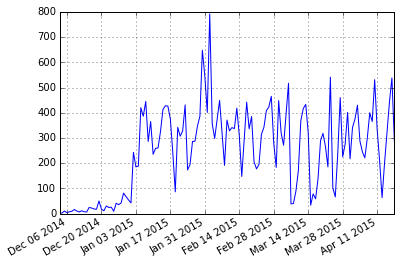

In [54]:
total_df.date_time.value_counts().plot()

In [55]:
total_df = total_df.rename(columns = {'user_neighborhood' : 'neighborhood'})

In [56]:
total_df.to_csv('../craigslist_data/df_final.csv', index = None)

In [57]:
total_df.date_time.value_counts().order()

2014-12-03     1
2014-12-04     2
2014-12-06     3
2014-12-14     6
2014-12-11     6
2014-12-07     7
2014-12-13     7
2014-12-08     9
2014-12-25     9
2014-12-10    10
2014-12-05    10
2014-12-12    11
2014-12-21    11
2014-12-09    16
2014-12-18    17
...
2015-03-13    433
2015-02-17    442
2015-04-16    443
2015-01-07    445
2015-03-02    448
2015-02-06    449
2015-03-27    460
2015-02-27    465
2015-03-06    517
2015-04-10    531
2015-04-17    538
2015-03-23    541
2015-01-31    546
2015-01-30    648
2015-02-02    792
Length: 137

In [ ]:
len(html_master_pre_list)

In [ ]:
html_master_df = []
for html in html_no_dup:
    html_master_df.append(str(html))
html_master_df = pd.DataFrame(html_master_df).rename(columns = {0:'url'})

In [ ]:
html_master_df.info()

In [ ]:
html_master_df.to_csv('../craigslist_data/html_master_df.csv')

In [55]:
bathrooms_df = df_temp.loc[:,df_dict['bathrooms']]
bathrooms_df = bathrooms_df[bathrooms_df.bathrooms.notnull()]

bedrooms_df = df_temp.loc[:,df_dict['bedrooms']]
bedrooms_df = bedrooms_df[bedrooms_df.bedrooms.notnull()]

cats_OK_df = df_temp.loc[:,df_dict['cats_OK']]
cats_OK_df = cats_OK_df[cats_OK_df.cats_OK.notnull()].astype(float)

dogs_OK_df  = df_temp.loc[:,df_dict['dogs_OK']]
dogs_OK_df  = dogs_OK_df[dogs_OK_df.dogs_OK.notnull()]

furnished_df   = df_temp.loc[:,df_dict['furnished']]
furnished_df   = furnished_df[furnished_df.furnished.notnull()]

smoking_df   = df_temp.loc[:,df_dict['no smoking']]
smoking_df   = smoking_df[smoking_df['no smoking'].notnull()]

rent_df   = df_temp.loc[:,df_dict['rent']]
rent_df   = rent_df[rent_df.rent.notnull()]

sq_ft_df   = df_temp.loc[:,df_dict['sq_ft']]
sq_ft_df   = sq_ft_df[sq_ft_df.sq_ft.notnull()]

wheelchair_df   = df_temp.loc[:,df_dict['wheelchair']]
wheelchair_df   = wheelchair_df[wheelchair_df.wheelchair.notnull()]

NameError: name 'df_temp' is not defined

In [ ]:
df_list = [bathrooms_df, bedrooms_df, cats_OK_df, dogs_OK_df,
furnished_df, smoking_df, rent_df, sq_ft_df, wheelchair_df]

In [ ]:
for num, df in enumerate(df_list):
    df.to_csv('map_dfs/%s.csv' % temp_cols[num])